In [126]:
import matplotlib
from matplotlib import pyplot as plt
import osmnx
import networkx as nx
import random
import igraph as ig
import warnings
from tqdm.notebook import tqdm 

tqdm.pandas()

SMALL_SIZE = 5
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)

random.seed(1234)

COLORS = {"S": "#2f4b7c",
          "E": "#ffa600",
          "I": "#f95d6a",
          "R": "#a05195",
          "D": "#003f5c",
          "C": "#ff7c43",
          "X": "#665191",
          "Y": "#d45087"}

warnings.filterwarnings("ignore")

/opt/python/envs/default/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [127]:
%load_ext watermark
%watermark --iversions -v -a "Chris von Csefalvay" -gu "chrisvoncsefalvay"

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Author: Chris von Csefalvay

Github username: chrisvoncsefalvay

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 7.31.1

matplotlib: 3.5.1
osmnx     : 1.2.0
networkx  : 2.8.2
igraph    : 0.9.11



In [128]:
location = "Oxford, England"
crs = 27700

In [129]:
%%time

graph = osmnx.graph_from_place(location, network_type="drive")

CPU times: user 7.44 s, sys: 27.6 ms, total: 7.46 s
Wall time: 7.47 s


In [130]:
graph = osmnx.distance.add_edge_lengths(graph)

In [131]:
osm_ids = list(graph.nodes)
graph = nx.relabel.convert_node_labels_to_integers(graph)

osm_id_vals = {k: v for k, v in zip(graph.nodes, osm_ids)}
nx.set_node_attributes(graph, osm_id_vals, "osmid")

In [132]:
i_graph = ig.Graph(directed=True)
i_graph.add_vertices(graph.nodes)
i_graph.add_edges(graph.edges())
i_graph.vs["osmid"] = osm_ids
i_graph.es["length"] = list(nx.get_edge_attributes(graph, "length").values())

In [133]:
nodes, edges = osmnx.graph_to_gdfs(graph)
nodes.geometry = nodes.geometry.to_crs(crs)
edges.geometry = edges.geometry.to_crs(crs)

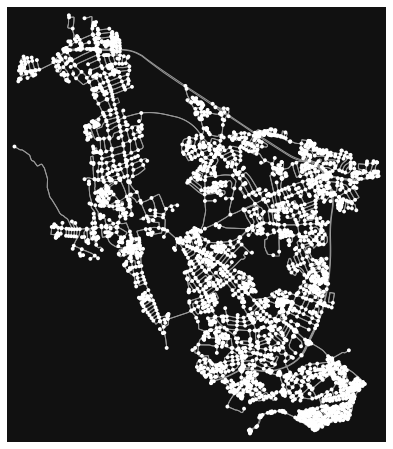

In [134]:
osmnx.plot_graph(graph)

In [135]:
%%time

hospitals = osmnx.geometries.geometries_from_place(location, tags={"amenity": ["hospital"]})[["geometry"]]
hospitals.geometry = hospitals.geometry.to_crs(crs)

CPU times: user 155 ms, sys: 12 ms, total: 167 ms
Wall time: 172 ms


/opt/python/envs/default/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/python/envs/default/lib/python3.8/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/opt/python/envs/default/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


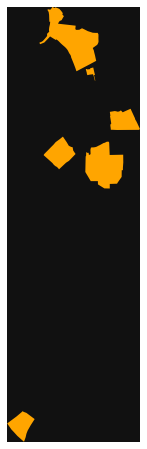

In [136]:
osmnx.plot_footprints(hospitals)

In [137]:
%%time

residential = osmnx.geometries.geometries_from_place(location, tags={"building": ["house", "apartments", "residential", "detached", "terrace"]})[["geometry"]].sort_index()
residential.geometry = residential.geometry.to_crs(crs)

CPU times: user 6.72 s, sys: 43.6 ms, total: 6.76 s
Wall time: 6.77 s


/opt/python/envs/default/lib/python3.8/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
/opt/python/envs/default/lib/python3.8/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):


/opt/python/envs/default/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/python/envs/default/lib/python3.8/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/opt/python/envs/default/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


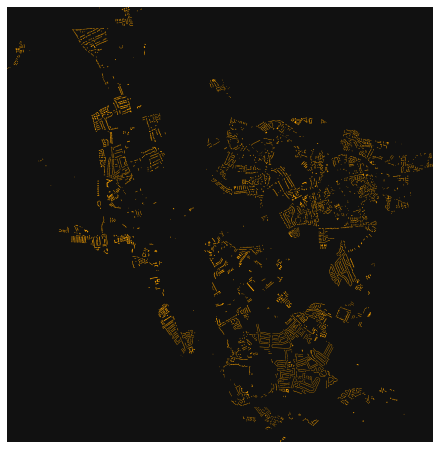

In [138]:
osmnx.plot_footprints(residential)

In [139]:
pgraph = osmnx.project_graph(graph, crs)
hospitals["nearest_node"] = osmnx.distance.nearest_nodes(pgraph, hospitals.geometry.centroid.x, hospitals.geometry.centroid.y)
residential["nearest_node"] = osmnx.distance.nearest_nodes(pgraph, residential.geometry.centroid.x, residential.geometry.centroid.y)

In [168]:
def get_distance_to_nearest_hospital(source_node) -> float:
    distances = []
    for hospital_node in hospitals.nearest_node:
        path = i_graph.get_shortest_paths(source_node, hospital_node, weights="length", output="epath")[0]
        path_length = sum(list(map(lambda x: i_graph.es[x]["length"], path)))
        distances.append(path_length)
    return min(distances)

/opt/python/envs/default/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [169]:
%%time

residential = residential[residential.geometry.apply(lambda x: x.type != "Point")]
residential["distance_to_nearest_hospital"] = residential.nearest_node.apply(get_distance_to_nearest_hospital)

CPU times: user 1min 14s, sys: 2.79 ms, total: 1min 14s
Wall time: 1min 14s


<ipython-input-168-a244ddc95c90>:4: RuntimeWarning: Couldn't reach some vertices at src/paths/dijkstra.c:442
  path = i_graph.get_shortest_paths(source_node, hospital_node, weights="length", output="epath")[0]


In [149]:
print("sdfgsdfgs")

sdfgsdfgs


/opt/python/envs/default/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [170]:
residential

/opt/python/envs/default/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


geometry 
 nearest_node 
 distance_to_nearest_hospital 
 
 
 element_type 
 osmid 
 
 
 
 
 
 
 
 relation 
 1526090 
 POLYGON ((453988.434 206162.534, 453972.781 20... 
 2261 
 148.576 
 
 
 1764676 
 POLYGON ((452874.829 207119.681, 452876.256 20... 
 1677 
 2107.834 
 
 
 2961197 
 POLYGON ((453874.272 203238.998, 453875.060 20... 
 292 
 1187.013 
 
 
 3020237 
 POLYGON ((452013.385 206692.009, 452015.819 20... 
 2498 
 2862.766 
 
 
 6655288 
 POLYGON ((450671.421 207680.844, 450679.076 20... 
 335 
 4723.420 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 way 
 1064914414 
 POLYGON ((453014.376 205689.797, 453015.247 20... 
 1071 
 1370.565 
 
 
 1064914415 
 POLYGON ((453015.336 205684.502, 453016.269 20... 
 1071 
 1370.565 
 
 
 1064914734 
 POLYGON ((452826.361 205803.229, 452824.641 20... 
 1075 
 1479.669 
 
 
 1064916387 
 POLYGON ((452830.463 205809.801, 452843.256 20... 
 1075 
 1479.669 
 
 
 1064916388 
 POLYGON ((452837.349 205793.678, 452835.838 20... 
 1075 
 1479.669 
 
 
 
 14738 rows × 3 columns

/opt/python/envs/default/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/python/envs/default/lib/python3.8/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/opt/python/envs/default/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/python/envs/default/lib/python3.8/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version in

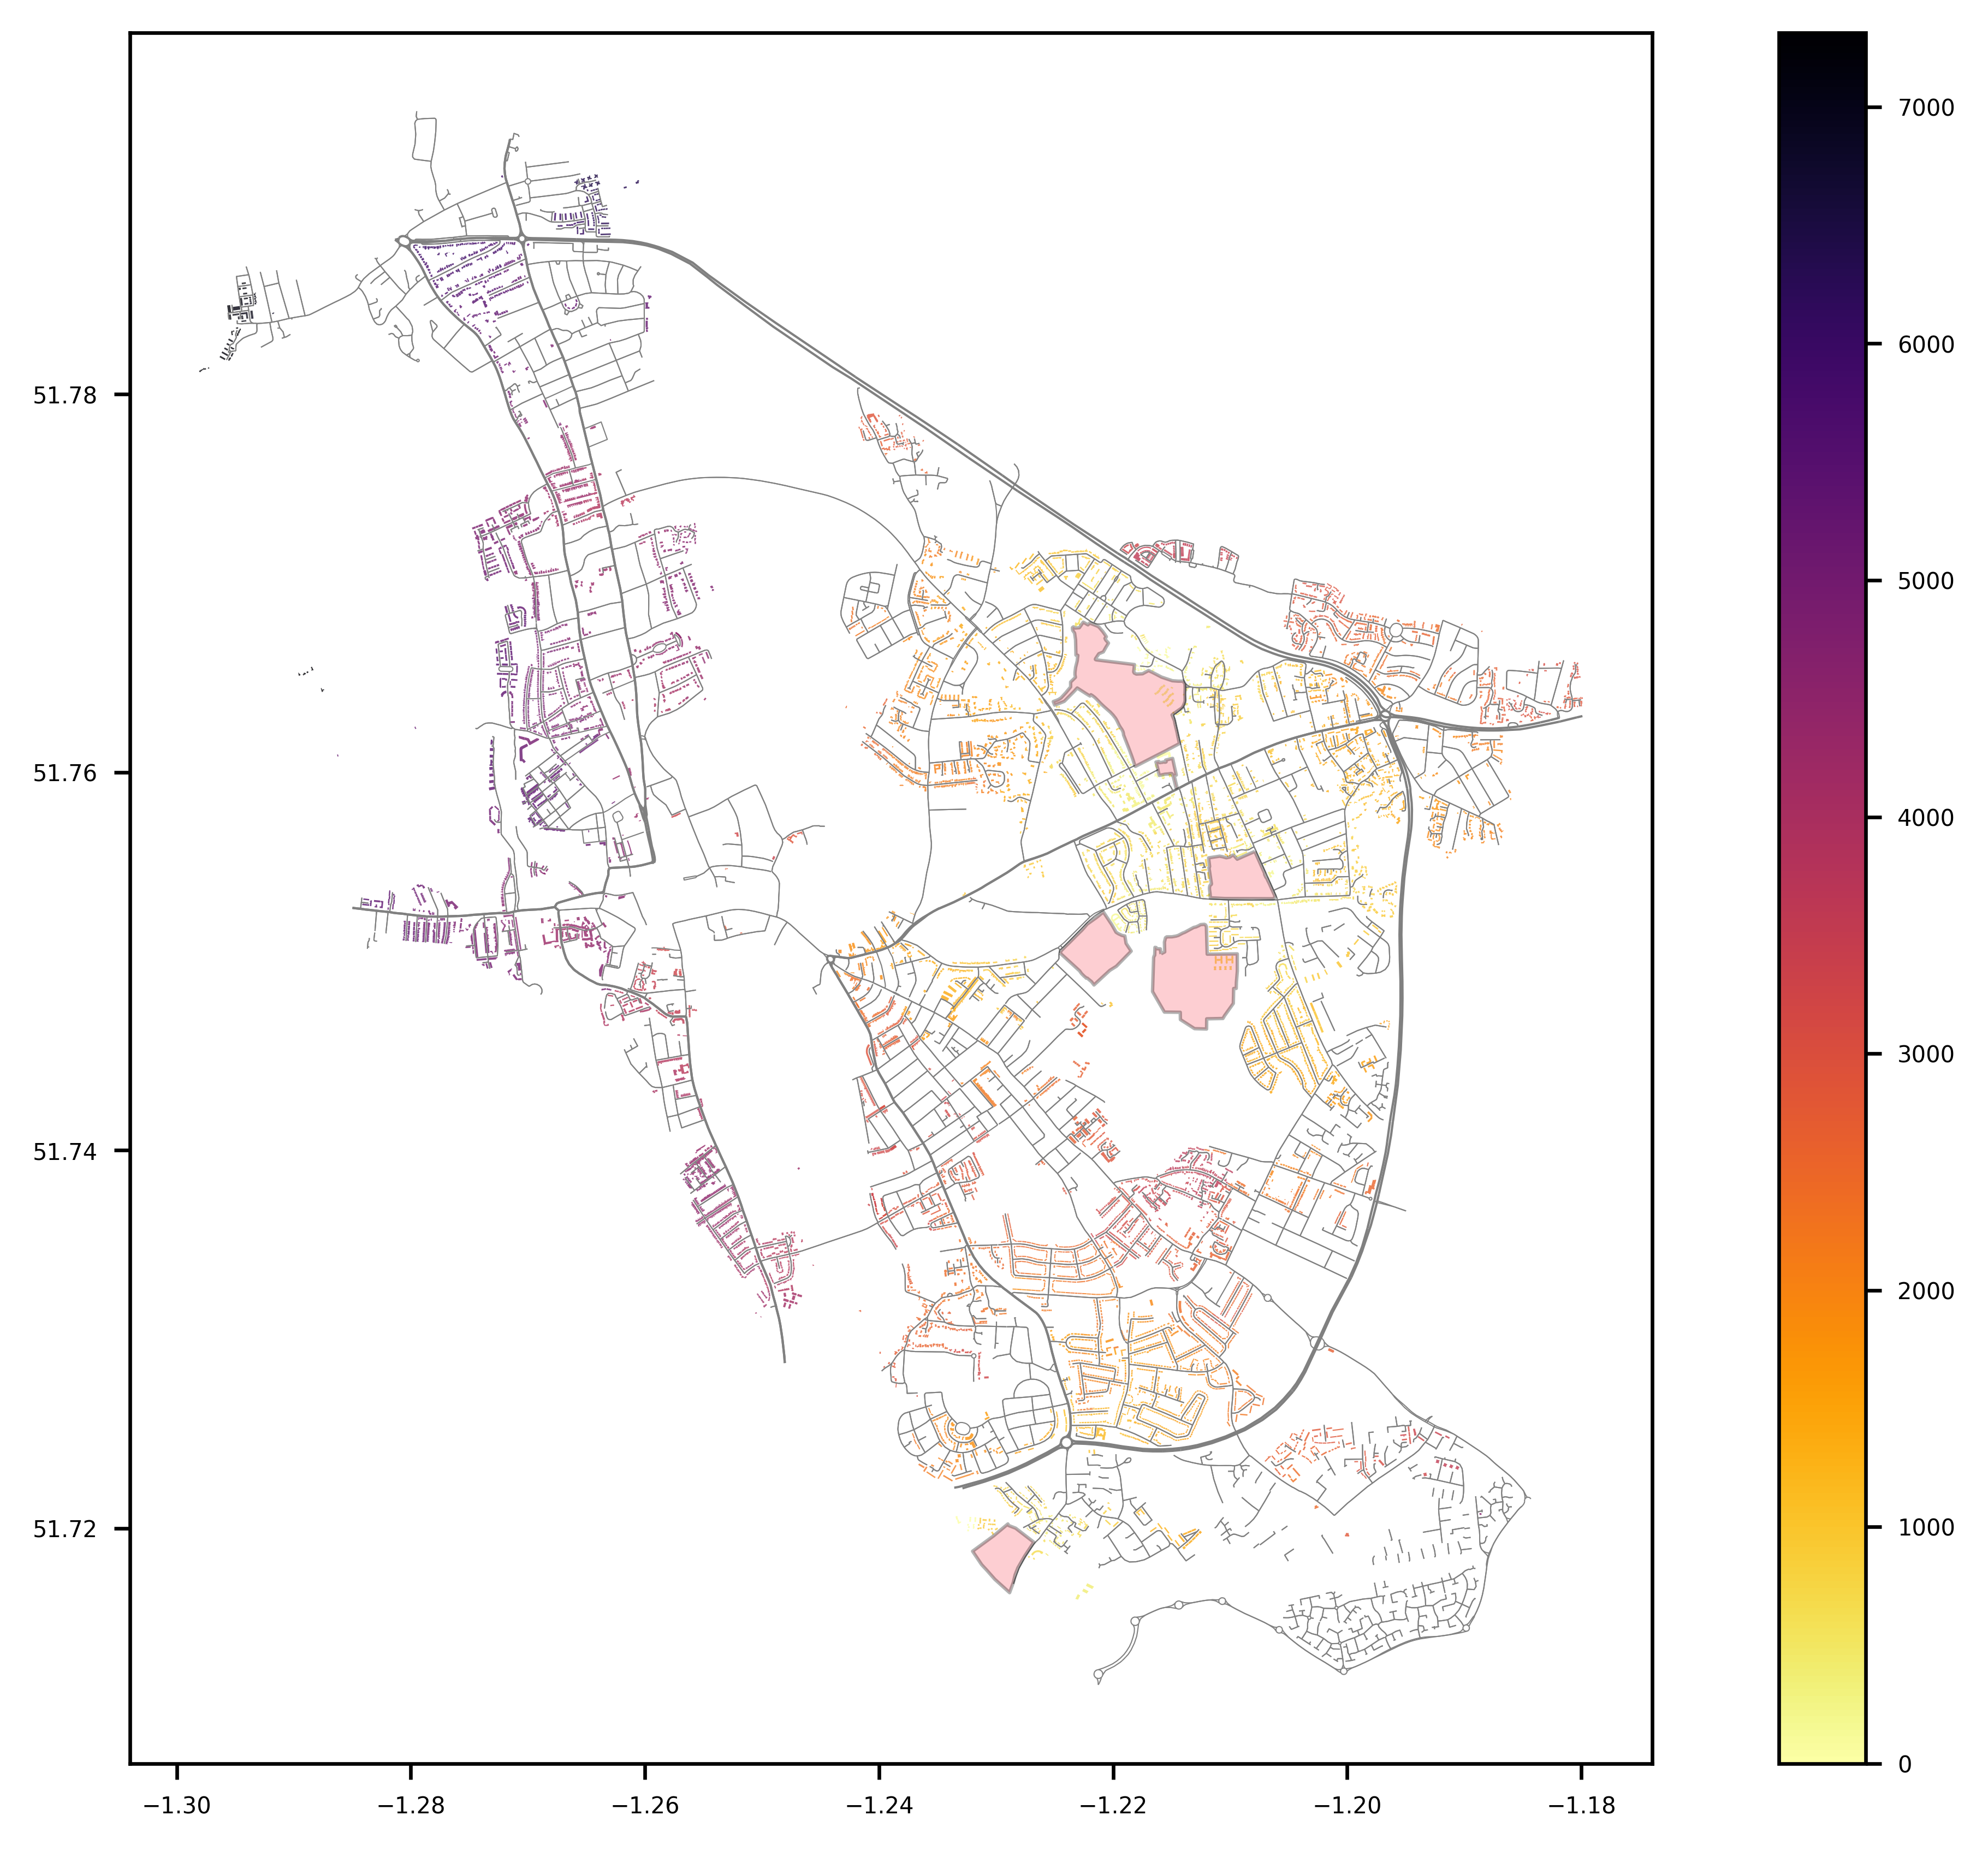

In [174]:
fig = plt.figure(facecolor="w", figsize=(10, 7), dpi=600)
ax = fig.add_subplot(111, axisbelow=True)

edges.geometry = edges.geometry.to_crs(4326)
hospitals.geometry = hospitals.geometry.to_crs(4326)
residential.geometry = residential.geometry.to_crs(4326)

arterial_roads = edges.loc[edges.highway.isin(["motorway", "trunk", "primary", "primary_link"])]
secondary_roads = edges.loc[edges.highway.isin(["secondary", "tertiary", "residential"])]

arterial_roads.plot(ax=ax, lw=0.5, color='gray', zorder=3)
secondary_roads.plot(ax=ax, lw=0.25, color='gray', zorder=3)
hospitals.plot(ax=ax, facecolor=COLORS["I"], linewidth=0.75, edgecolor="k", zorder=4, alpha=0.3)
residential.plot("distance_to_nearest_hospital", cmap="inferno_r", legend=True, alpha=0.8, zorder=2, ax=ax)

plt.savefig("hospital_isodistance.pdf")